<h2>Data Discription</h2>

The data is generated using 4 different non-linear functions,
\begin{align*}
    g_0(x) &= a_0\sin(x), \\
    g_1(x) &= a_1\sqrt{x}, \\
    g_2(x) &= a_2x^3+0.3x, \\
    g_3(x) &= a_3\log(1+x),
\end{align*}
where $a_i\sim Unif(0.1,10)$, ($i\in \{0,1,2,3 \}$). Based on these functions we have a procedure for when two time-series are dependent or not.


When the two time-series are dependent then we first create a time-series, $X$, based on two different $g$ functions. Then the other time-series, $Y$, is a $g$ function of $X$. When the time-series are independent then $Y$ is generated using the two other $g$ functions than $X$. When they are dependent they are denoted class 1 and when they are not they are denoted class 0. An example of a dependent and independent realisation is seen below.

<img src="non_lin_plots/independent.png" width="auto" height="300">
<img src="non_lin_plots/dependent.png" width="auto" height="300">

<h2>Neural Network Setup</h2>

In the following code we use $50,000$ realizations of $X,Y$, where len($X$)=len($Y$)=$1,000$

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import train_test_split as tts
import torch.nn as nn
from tqdm import tqdm
import nn_module as NN

In [63]:
data, labels = NN.load_data('data_(10000_1000_2)/nonlin_data.npy')

In [154]:
batch_size = 100
epochs = 20
learning_rate = 0.0001
hidden_layers = [500, 500, 500]
SNR = 10

The input above gives the feed forward neural network:

<table>
  <tr>
    <th>Input Layer</th>
    <th>Hidden Layers</th>
    <th>Output Layer</th>
  </tr>
  <tr>
    <td>len(X)*2=2,000</td>
    <td>-- 500 -- 500 -- 500 --</td>
    <td>2</td>
  </tr>
</table>

<h2>Signal to noise ratio</h2>

We have tried without extra noise on the $X,Y$ realisations and got that we could classify both class 0 and 1 approximately 90\% accurately. Hence, we tried adding some noise based on an SNR.

In [155]:
P_noise = np.mean(data**2, axis=1)/np.full((data.shape[0], 
                                            data.shape[2]), SNR)

noise = np.zeros(data.shape)
mu = np.zeros((data.shape[1], 1))
for i in range(len(data)):
    Xi_noise = np.random.normal(mu.copy(), 
                                P_noise[i][0], 
                                (data.shape[1], 1))
    
    Yi_noise = np.random.normal(mu.copy(), 
                                P_noise[i][1], 
                                (data.shape[1], 1))

    noise[i] = np.concatenate([Xi_noise, Yi_noise], axis=1)

data += noise

In [156]:
# This block converts data from np to torch and adjusts 
# to the desired format for the training and test. 

data_trn_np, data_tst_np, label_trn_np, label_tst_np = \
    tts(data, labels, test_size=0.1)

label_train_reshaped = np.zeros((len(label_trn_np), 2))
label_test_reshaped = np.zeros((len(label_tst_np), 2))

for i, trn in enumerate(label_trn_np):
    label_train_reshaped[i, int(trn)] = 1

for i, tst in enumerate(label_tst_np):
    label_test_reshaped[i, int(tst)] = 1

data_train = NN.NumbersDataset(data_trn_np, label_train_reshaped)
data_test = NN.NumbersDataset(data_tst_np, label_test_reshaped)

loader_train = DataLoader(
    data_train, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True
)

loader_test = DataLoader(
    data_test, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True
)

input_size = int(data_trn_np.shape[1]*data_trn_np.shape[2])


In [157]:
# creating device - Either GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [158]:
# Specifying FNN, loss function, and optimizer 
model = NN.Network(
    hidden_layer_dims=hidden_layers,
    input_size=input_size,
    device=device
).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [159]:
# Train the model
num_steps = len(loader_train)
loss_list = []
loss_avg_trn = []
loss_avg_tst = []
for epoch in tqdm(range(epochs)):
    for i, (value, label) in enumerate(loader_train):
        sample = value.reshape(batch_size, -1).to(device)
        label = label.view(label.shape[0], 2).to(device)
        
        # forward
        output = model(sample)
        loss = criterion(output, label)
        loss_list.append(loss.item())
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    with torch.no_grad():
        loss_test = []
        for value, label in loader_test:
            sample = value.reshape(batch_size, -1).to(device)
            label = label.view(label.shape[0], 2).to(device)
            
            output = model(sample)
            loss = criterion(output, label)
            
            loss_test.append(loss.item())
    
    loss_avg_trn.append(np.mean(np.array(loss_list)))
    loss_avg_tst.append(np.mean(np.array(loss_test)))
    
    loss_list = []
    loss_test = []
    

100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


In [160]:
with torch.no_grad():
    out_list = []
    label_list = []

    labs1d = []
    pred1d = []
    n_samples = 0
    n_diff = 0
    
    for value, label in loader_test:
        sample = value.reshape(batch_size, -1).to(device)
        label = label.view(label.shape[0], 2).to(device)
        label_list += label.tolist()
        
        output = model(sample)
        out_list += output.tolist()
        _, pred = torch.max(output, 1)
        _, labs = torch.max(label, 1)
        n_diff += torch.abs(pred-labs)

        pred1d += pred.tolist()
        labs1d += labs.tolist()

        n_samples += 1
    
pred1d = np.array(pred1d)
labs1d = np.array(labs1d)

In [161]:
path = f"non_lin_plots/snr{SNR}/"
acc = np.count_nonzero(pred1d == labs1d)/len(labs1d)
acc0 = (len(pred1d[np.where(labs1d==0)])-
        np.sum(pred1d[np.where(labs1d==0)]))/len(np.where(labs1d==0)[0])
        
acc1 = np.sum(pred1d[np.where(labs1d==1)])/len(np.where(labs1d==1)[0])

print(f"{acc*100:.5f}% overall accuracy")
print(f"{acc0*100:.5f}% of 0 guessed correctly")
print(f"{acc1*100:.5f}% of 1 guessed correctly")


# Use the open() function to create a file object in append mode
with open(path+"accuracies.txt", "w") as f:
    # Use the write() method of the file object to append text to the file
    f.write(f"{acc*100:.5f}% overall accuracy\n")
    f.write(f"{acc0*100:.5f}% of 0 guessed correctly\n")
    f.write(f"{acc1*100:.5f}% of 1 guessed correctly")


91.50000% overall accuracy
91.37255% of 0 guessed correctly
91.63265% of 1 guessed correctly


The best result we have gotten were without noise and is around 91\% accuracy in the 3 tests. When setting the SNR=0.1 we still get around 75\% accuracy, but at SNR=0.01 we get around 50\% accuracy for both class 0 and 1. 

<h2>Plotting</h2>
The plot below is to ensure we are not overfitting the model. 

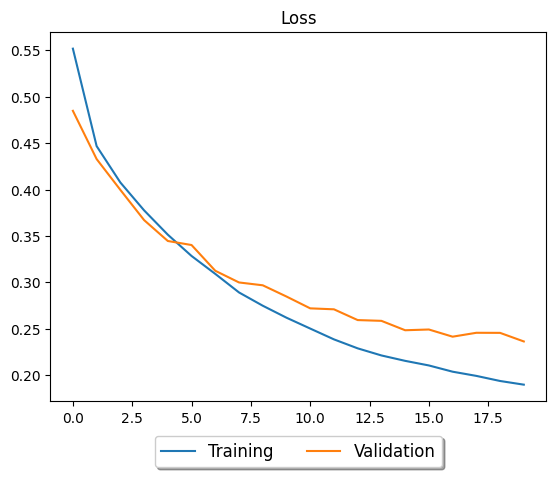

In [162]:
plt.plot(np.array(loss_avg_trn), label="Training")
plt.plot(np.array(loss_avg_tst), label="Validation")
plt.title('Loss')
plt.legend(bbox_to_anchor=(0.5, -0.07), loc="upper center", fancybox=True, shadow=True, ncol=2, fontsize=12)
plt.savefig(path+'nn_loss.pdf')
plt.show()

In [163]:
all_X = []

for X, y in loader_test:
  all_X.append(X)

test_X = torch.cat(all_X, dim=0).numpy()

wrong_guess_idx = np.where(pred1d != labs1d)
right_guess_idx = np.where(pred1d == labs1d)

In [164]:
wrong_guess = test_X[wrong_guess_idx]
right_guess = test_X[right_guess_idx]

wrong_guess_lab = labs1d[wrong_guess_idx]
right_guess_lab = labs1d[right_guess_idx]

wrong_guess_lab_pred = pred1d[wrong_guess_idx]
right_guess_lab_pred = pred1d[right_guess_idx]

corr_wrong = np.zeros(len(wrong_guess))
corr0_wrong = []
corr1_wrong = []
for i in range(len(wrong_guess)):
    corr_wrong[i] = np.corrcoef(wrong_guess[i,:,0], wrong_guess[i,:,1])[0,1]

    if wrong_guess_lab[i] == 0:
        corr0_wrong.append(corr_wrong[i])
    else:
        corr1_wrong.append(corr_wrong[i])

corr0_wrong = np.array(corr0_wrong)
corr1_wrong = np.array(corr1_wrong)

corr_right = np.zeros(len(right_guess))
corr0_right = []
corr1_right = []
for i in range(len(right_guess)):
    corr_right[i] = np.corrcoef(right_guess[i,:,0], right_guess[i,:,1])[0,1]

    if right_guess_lab[i] == 0:
        corr0_right.append(corr_right[i])
    if right_guess_lab[i] == 1:
        corr1_right.append(corr_right[i])

corr0_right = np.array(corr0_right)
corr1_right = np.array(corr1_right)

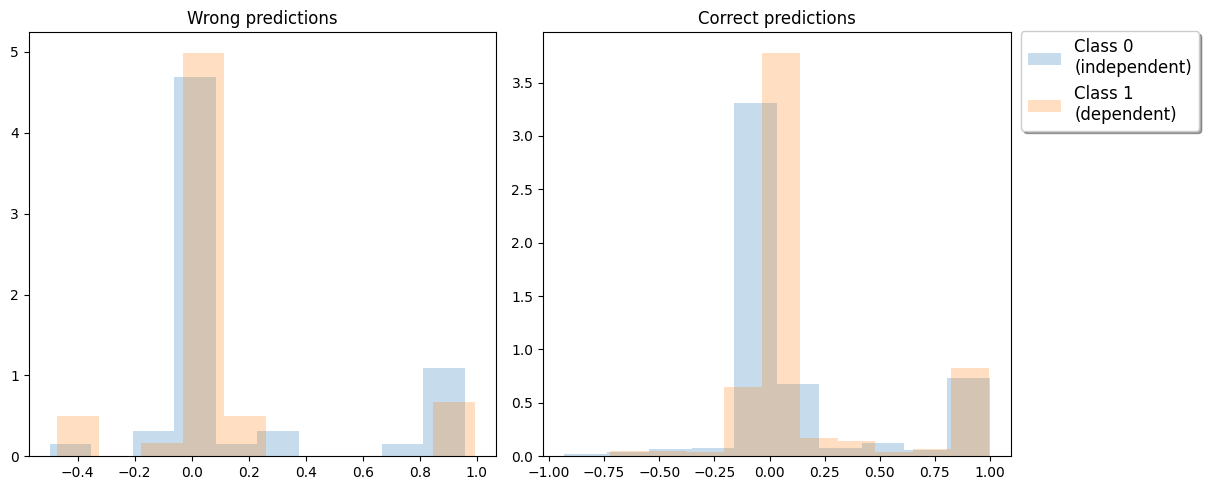

In [165]:
x_wrong = np.linspace(0, len(corr_wrong), len(corr_wrong))

figsize = (12, 5)
fig, axs = plt.subplots(1, 2, figsize=figsize)
#fig.suptitle('Validation vs Training', fontsize=18)

axs[0].hist(corr0_wrong, alpha=0.25, label='Class 0 (independent)', density=True)
axs[0].hist(corr1_wrong, alpha=0.25, label='Class 1 (dependent)', density=True)
axs[0].set_title('Wrong predictions')

axs[1].hist(corr0_right, alpha=0.25, label='Class 0 \n(independent)', density=True)
axs[1].hist(corr1_right, alpha=0.25, label='Class 1 \n(dependent)', density=True)
axs[1].set_title('Correct predictions')

axs[1].legend(bbox_to_anchor=(1.42, 0.885), loc="center right", fancybox=True, shadow=True, ncol=1, fontsize=12)
#axs[0].legend(bbox_to_anchor=(0.5, -0.07), loc="upper center", fancybox=True, shadow=True, ncol=3, fontsize=12)
plt.tight_layout()
plt.savefig(path+'nn_pred.pdf')
plt.show()

# plt.plot(x_wrong[:len(corr0_wrong)], corr0_wrong, '*', alpha=0.25, label='Class 0 (independent)')
# plt.plot(x_wrong[len(corr0_wrong):], corr1_wrong, '*', alpha=0.25, label='Class 1 (dependent)')
# plt.title('Wrong guesses')
# plt.legend(bbox_to_anchor=(0.5, -0.07), loc="upper center", fancybox=True, shadow=True, ncol=2, fontsize=12)
# plt.show()

# x_right = np.linspace(0, len(corr_right), len(corr_right))
# plt.plot(x_right[:len(corr0_right)], corr0_right, '*', alpha=0.25, label='Class 0 (independent)')
# plt.plot(x_right[len(corr0_right):], corr1_right, '*', alpha=0.25, label='Class 1 (dependent)')
# plt.title('Right guesses')
# plt.legend(bbox_to_anchor=(0.5, -0.07), loc="upper center", fancybox=True, shadow=True, ncol=2, fontsize=12)
# plt.show()

In [129]:
# for i in range(10):
#     plt.plot(wrong_guess[i], alpha=0.5)
#     plt.title(f'True class {wrong_guess_lab[i]} guessed {wrong_guess_lab_pred[i]}, corr={corr_wrong[i]:.5f}')
#     plt.show()

(10000, 1000, 2)

In [74]:
import torch.nn.functional as F

out = model(torch.concat([torch.zeros(1000), torch.ones(1000)]))
classification = torch.argmax(out).item()

if classification == 0:
    dependency = 'independent'
else:
    dependency = 'dependent'

print(f"The tested data is {dependency} \nCertainty independent = {F.softmax(out, dim=0)[0]:.5f}\nCertainty dependent   = {F.softmax(out, dim=0)[1]:.5f}")


# anders test:
coup = np.load('dat/coupled_data.npy')
ucoup = np.load('dat/uncoupled_data.npy')

coup_t = torch.from_numpy(coup).to(torch.float32)
ucoup_t = torch.from_numpy(ucoup).to(torch.float32)

out = model(ucoup_t)
classification = torch.argmax(out).item()

if classification == 0:
    dependency = 'independent'
else:
    dependency = 'dependent'

print(f"The tested data is {dependency} \nCertainty independent = {F.softmax(out, dim=0)[0]:.5f}\nCertainty dependent   = {F.softmax(out, dim=0)[1]:.5f}")


The tested data is dependent 
Certainty independent = 0.11393
Certainty dependent   = 0.88607
The tested data is dependent 
Certainty independent = 0.26660
Certainty dependent   = 0.73340


## Ideas for future work on this

The plots above (histogram and the other plots in that shell) shows that our network makes an estimate that the Corrcoef is not able to do any better. 

An idea is to do the same with KSG. If there is a a pattern on plots similar to the ones above then the KSG could be used to improve the FFN estimator. 

One final thought could be to implement RNN and see if this is a better estimator.